# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import prettytable

In [0]:
#USER DEFINED FUNCTIONS

#changing reviews with score less than 3 to be positive and vice-versa
def data_filter(filtered_data):
    actualScore = filtered_data['Score']
    positiveNegative = actualScore.map(partition) 
    filtered_data['Score'] = positiveNegative
    return filtered_data["Score"]


# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file #Training Variants
downloaded = drive.CreateFile({'id':'1PPCURbwWREuTo7ZgIt9MZv26tpsAp9Bs'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Reviews.csv')

downloaded1 = drive.CreateFile({'id':'1PPC'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Reviews.csv')

downloaded = drive.CreateFile({'id':'1PPCURbwWREuTo7ZgIt9MZv26tpsAp9Bs'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Reviews.csv')

downloaded = drive.CreateFile({'id':'1PPCURbwWREuTo7ZgIt9MZv26tpsAp9Bs'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Reviews.csv')

#3. Read file as panda dataframe
import pandas as pd
data = pd.read_csv('Reviews.csv')

    100% |████████████████████████████████| 993kB 19.7MB/s 


In [0]:
data.head(20)

In [0]:
#Converting from timestamp to datetime object.

from datetime import datetime
Time = []
for i in list(data["Time"]):
  Time.append(datetime.fromtimestamp(i).strftime('%d-%m-%Y'))
  
data["Time"] = pd.to_datetime(Time)
data = data.sort_values("Time") 

In [0]:
data.head(20)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,1999-02-12,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-06-12,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
451877,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-06-12,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,1999-06-12,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,1999-08-10,EVERY book is educational,this witty little book makes my son laugh at l...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
230268,230269,B00004RYGX,A1B2IZU1JLZA6,Wes,19,23,1,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
374342,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,1,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
451863,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,1,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,5,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#Reading equal amount of positive and negative data.

filtered_data = data

'''
filtered_data_1 = data[data["Score"]>3][0:25000]
filtered_data_2 = data[data["Score"]<=2][0:25000]

filtered_data_1["Score"] = data_filter(filtered_data_1)
filtered_data_2["Score"] = data_filter(filtered_data_2)
'''

'''
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa

def data_filter(filtered_data):
    actualScore = filtered_data['Score']
    positiveNegative = actualScore.map(partition) 
    filtered_data['Score'] = positiveNegative
    return filtered_data["Score"]


#print("Number of data points in our data", filtered_data.shape)
#filtered_data.head(3)
'''

'\n# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).\ndef partition(x):\n    if x < 3:\n        return 0\n    return 1\n\n#changing reviews with score less than 3 to be positive and vice-versa\n\ndef data_filter(filtered_data):\n    actualScore = filtered_data[\'Score\']\n    positiveNegative = actualScore.map(partition) \n    filtered_data[\'Score\'] = positiveNegative\n    return filtered_data["Score"]\n\n\n#print("Number of data points in our data", filtered_data.shape)\n#filtered_data.head(3)\n'

In [0]:
'''
#Stacking both positive and negative data
filtered_data = filtered_data_1.append(filtered_data_2, ignore_index = True)

#Shuffling the data points to mix the data
from sklearn.utils import shuffle
filtered_data = shuffle(filtered_data)
'''

'\n#Stacking both positive and negative data\nfiltered_data = filtered_data_1.append(filtered_data_2, ignore_index = True)\n\n#Shuffling the data points to mix the data\nfrom sklearn.utils import shuffle\nfiltered_data = shuffle(filtered_data)\n'

In [0]:
#Calling function partition
filtered_data["Score"] = filtered_data["Score"].map(partition)

In [0]:
print("Number of data points in our data", filtered_data.shape)
filtered_data.head()

Number of data points in our data (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-02-12,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-06-12,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
451877,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-06-12,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-06-12,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-08-10,EVERY book is educational,this witty little book makes my son laugh at l...


In [0]:
filtered_data.reset_index(drop = True)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-02-12,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
1,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-06-12,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
2,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-06-12,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-06-12,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-08-10,EVERY book is educational,this witty little book makes my son laugh at l...
5,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
6,230269,B00004RYGX,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
7,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
8,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
9,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...


In [0]:
'''display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)'''

'display = pd.read_sql_query("""\nSELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)\nFROM Reviews\nGROUP BY UserId\nHAVING COUNT(*)>1\n""", con)'

In [0]:
'''print(display.shape)
display.head()'''

'print(display.shape)\ndisplay.head()'

In [0]:
#display[display['UserId']=='AZY10LLTJ71NX']

In [0]:
#display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
'''display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()'''

'display= pd.read_sql_query("""\nSELECT *\nFROM Reviews\nWHERE Score != 3 AND UserId="AR5J8UI46CURR"\nORDER BY ProductID\n""", con)\ndisplay.head()'

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(393933, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.29901100176971

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
'''display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()'''

'display= pd.read_sql_query("""\nSELECT *\nFROM Reviews\nWHERE Score != 3 AND Id=44737 OR Id=64422\nORDER BY ProductID\n""", con)\n\ndisplay.head()'

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(393931, 10)


1    336824
0     57107
Name: Score, dtype: int64

In [0]:
final.shape

(393931, 10)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4300]
print(sent_4900)
print("="*50)

It's a great book with adorable illustrations.  A true classic.  Kids love the poem and there is music that goes with it, if you can find it.  I think it's sung by Carol King.
Well if you have had this product before you know it is amazing.  I am not going to describe the taste but i will tell you the product was shipped neatly and fresh.  Everything tasted great and the expiration date was much further into the future than this would have ever lasted.  Top notch.
Cat thought the bubbles were interesting, but didn't go crazy over them. They smell funny, leave a residue, and don't maintain form when they touch down as advertised. I'll go pick up a big bottle of regular bubbles for him to chase. Not worth the price.
The previous reviewer's experience is lamentable but after reading the reviews for other Brussel's Bonsai & after reception of my own tree it's clear that his experience was the exception, not the rule.<br /><br />The tree arrived well-packaged, lush & green. The soil was moi

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

It's a great book with adorable illustrations.  A true classic.  Kids love the poem and there is music that goes with it, if you can find it.  I think it's sung by Carol King.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

It's a great book with adorable illustrations.  A true classic.  Kids love the poem and there is music that goes with it, if you can find it.  I think it's sung by Carol King.
Well if you have had this product before you know it is amazing.  I am not going to describe the taste but i will tell you the product was shipped neatly and fresh.  Everything tasted great and the expiration date was much further into the future than this would have ever lasted.  Top notch.
Cat thought the bubbles were interesting, but didn't go crazy over them. They smell funny, leave a residue, and don't maintain form when they touch down as advertised. I'll go pick up a big bottle of regular bubbles for him to chase. Not worth the price.
The previous reviewer's experience is lamentable but after reading the reviews for other Brussel's Bonsai & after reception of my own tree it's clear that his experience was the exception, not the rule.The tree arrived well-packaged, lush & green. The soil was moist & wrapped

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Cat thought the bubbles were interesting, but did not go crazy over them. They smell funny, leave a residue, and do not maintain form when they touch down as advertised. I will go pick up a big bottle of regular bubbles for him to chase. Not worth the price.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

It's a great book with adorable illustrations.  A true classic.  Kids love the poem and there is music that goes with it, if you can find it.  I think it's sung by Carol King.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Cat thought the bubbles were interesting but did not go crazy over them They smell funny leave a residue and do not maintain form when they touch down as advertised I will go pick up a big bottle of regular bubbles for him to chase Not worth the price 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 393931/393931 [02:59<00:00, 2198.18it/s]


In [0]:
preprocessed_reviews[1500]

'cat thought bubbles interesting not go crazy smell funny leave residue not maintain form touch advertised go pick big bottle regular bubbles chase not worth price'

In [0]:
#Used when 50% of positive and 50% of negative reviews are needed.
'''
final["New_Text"] = preprocessed_reviews

a = final[final["Score"]==0][0:500]
b = final[final["Score"]==1][0:500]

#Stacking both positive and negative data
a = a.append(b, ignore_index = True)

#Shuffling the data points to mix the data
from sklearn.utils import shuffle
a = shuffle(a)'''

'\nfinal["New_Text"] = preprocessed_reviews\n\na = final[final["Score"]==0][0:500]\nb = final[final["Score"]==1][0:500]\n\n#Stacking both positive and negative data\na = a.append(b, ignore_index = True)\n\n#Shuffling the data points to mix the data\nfrom sklearn.utils import shuffle\na = shuffle(a)'

In [0]:
#Train-Test Split

#X_train,X_test,y_train, y_test = train_test_split(preprocessed_reviews[0:len(preprocessed_reviews)], list(final["Score"][0:len(preprocessed_reviews)]), random_state = 42, test_size = 0.3, stratify = list(final["Score"][0:len(preprocessed_reviews)]))

X_train,X_test,y_train, y_test = train_test_split(preprocessed_reviews[0:50000], list(final["Score"][0:50000]), random_state = 42, test_size = 0.3, stratify = list(final["Score"][0:50000]))

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer(max_features = 500) #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train)
final_counts_test = count_vect.transform(X_test)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
print("="*50)
print("for test data")
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (35000, 500)
the number of unique words  500
for test data
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (15000, 500)
the number of unique words  500


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
final_bigram_counts = count_vect.fit_transform(X_train)
final_bigram_counts_test = count_vect.transform(X_test)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

print("="*50)
print("for test data")

print("the type of count vectorizer ",type(final_bigram_counts_test))
print("the shape of out text BOW vectorizer ",final_bigram_counts_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (35000, 500)
the number of unique words including both unigrams and bigrams  500
for test data
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (15000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(min_df=10, max_features = 500)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_train)
final_tf_idf_test = tf_idf_vect.transform(X_test)

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

print("="*50)
print("for test data")

print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (35000, 500)
the number of unique words including both unigrams and bigrams  500
for test data
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (15000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus for train data
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [0]:
# Train your own Word2Vec model using your own text corpus for test data
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8106623888015747), ('good', 0.8083468675613403), ('wonderful', 0.7978379726409912), ('excellent', 0.7682069540023804), ('awesome', 0.748454213142395), ('amazing', 0.7277643084526062), ('perfect', 0.7181200981140137), ('terrific', 0.7043402194976807), ('decent', 0.6753935217857361), ('fabulous', 0.6586343050003052)]
[('greatest', 0.8113981485366821), ('best', 0.7572190165519714), ('fowl', 0.7126210331916809), ('nastiest', 0.6662765741348267), ('disgusting', 0.6581308245658875), ('closest', 0.6505348086357117), ('biggest', 0.6475117802619934), ('hottest', 0.6424438953399658), ('encountered', 0.6375048160552979), ('hated', 0.6318227052688599)]


In [0]:
#Creating a word vocabulary based on training data.
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12177
sample words  ['grandmother', 'ever', 'told', 'swallow', 'gum', 'never', 'digested', 'stay', 'body', 'forever', 'wrong', 'least', 'comes', 'natural', 'nothing', 'artificial', 'feel', 'bad', 'top', 'really', 'tasty', 'better', 'get', 'super', 'market', 'terms', 'flavor', 'consistency', 'favor', 'try', 'use', 'make', 'healthy', 'curry', 'sauces', 'sometimes', 'add', 'dash', 'brown', 'rice', 'brings', 'new', 'life', 'love', 'long', 'time', 'since', 'takes', 'little', 'bit']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
#Converting each word of a review from training data into vector of len 50, adding them up and the finding an average. Hence converting training data into vector form.

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 35000/35000 [01:10<00:00, 496.58it/s]


35000
50


In [0]:
#Resulting vector representation of Training data
X_tr_w2v = sent_vectors

In [0]:
#Converting each word of a review from test data into vector of len 50, adding them up and the finding an average. Hence converting test data into vector form.

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 15000/15000 [00:32<00:00, 464.51it/s]

15000
50


In [0]:
#Resulting vector representation of reviews of Test data
X_ts_w2v = sent_vectors

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
#Training the TfidfVectorizer on Train data

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
#Converting each word of a review from Train data into Tfidf W2v vector representation of len 50. Hence converting Train data into vector form.

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 35000/35000 [12:15<00:00, 47.61it/s]


In [0]:
#Resulting vector representation of reviews of Train data
X_tr_tf = tfidf_sent_vectors

In [0]:
#Converting each word of a review from Test data into Tfidf W2v vector representation of len 50. Hence converting Test data into vector form.
#Test data is converted to vectors using w2v_model and TfidfVectorizer which were built on Training data.

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 15000/15000 [04:46<00:00, 52.39it/s]


In [0]:
#Resulting vector representation of reviews of Test data
X_ts_tf = tfidf_sent_vectors

## [5.1] Applying KNN brute force

In [0]:
# Common User defined function used.

#Plots AUC Score vs Neighbors 
def plot_best_hyperparameter(gridcv):            
    cv_result = pd.DataFrame(gridcv.cv_results_)      #gridcv.cv_results_ outputs dict object of cross validation score and train score. 
    '''cv = {
    "neighbors" : cv_result["param_n_neighbors"],
    "train score" : cv_result["mean_train_score"],
    "validation score" : cv_result["mean_test_score"]}'''

    #CV_score = pd.DataFrame(cv)
    
    #Plot for Train data
    plt.figure()
    plt.title("Best hyperparameter for train data")
    plt.plot(cv_result["param_n_neighbors"], cv_result["mean_train_score"])
    plt.plot(cv_result["param_n_neighbors"], cv_result["mean_test_score"])
    plt.xticks(rotation=90)
    plt.xlabel("Neighbors/K")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.show()
    
    '''Plot for Validation data
    plt.figure()
    plt.title("Best hyperparameter for validation data")
    plt.plot(cv_result["param_n_neighbors"], cv_result["mean_test_score"])
    plt.xticks(rotation=90)
    plt.xlabel("Neighbors")
    plt.ylabel("AUC Score")
    plt.show()'''


def plot_roc_curve(test_y, predict_proba_y):     #Plots ROC Curve
    
    fpr, tpr, threshold = roc_curve(test_y, predict_proba_y)
    auc_area = metrics.auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', linewidth = 2,label = "AUC: %0.2f" %auc_area)
    plt.plot([0,1],[0,1], linewidth = 2, linestyle="--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(loc = "lower right")
    plt.show()
    

    
def plot_confusion_mat(test_y, predict_proba_y):    #Plots Confusion Matrix

    cnf_mat = confusion_matrix(test_y, predict_proba_y)
    cnf_df = pd.DataFrame(cnf_mat, index = ["Actual: 0", "Actual: 1"], columns = ["Predicted: 0", "Predicted: 1"], dtype= float)

    plt.figure(figsize=(5,3))
    plt.title("Confusion Matrix")
    sns.heatmap(cnf_df, annot = True, fmt = "g")


### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

{'n_neighbors': 93}


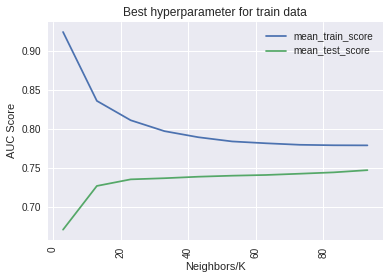

In [0]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#Parameters
params = {"n_neighbors":[3,13,23,33,43,53,63,73,83,93]
         }

knn_bow = KNeighborsClassifier(algorithm = "brute")

gridcv = GridSearchCV(knn_bow, params, scoring = 'roc_auc', cv = 5)
gridcv.fit(final_bigram_counts, y_train)
print(gridcv.best_params_)
bst_paramtr = gridcv.best_params_["n_neighbors"]

#Plots the graph for all  parameters to find best hyperparameter.
plot_best_hyperparameter(gridcv)

AUC for KNN with BOW for brute force method:  0.7412674463174048


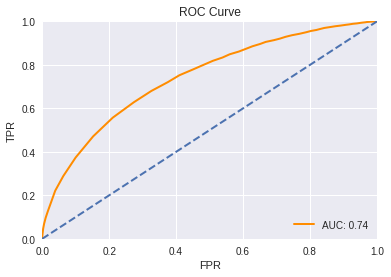

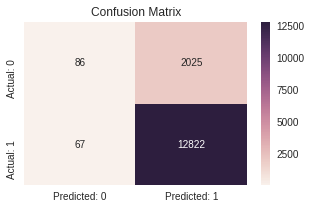

In [0]:
from sklearn.metrics import roc_auc_score

knn_bow_1 = KNeighborsClassifier(n_neighbors = bst_paramtr , algorithm = "brute")
knn_bow_1.fit(final_bigram_counts, y_train)

y_predict_proba_bow = knn_bow_1.predict_proba(final_bigram_counts_test)[:,1]
y_predict_bow = knn_bow_1.predict(final_bigram_counts_test)

roc_auc = roc_auc_score(y_test, y_predict_proba_bow)
print("AUC for KNN with BOW for brute force method: ", roc_auc)

#Plots ROC curve
plot_roc_curve(y_test, y_predict_proba_bow)

#Plots Confusion matrix
plot_confusion_mat(y_test, y_predict_bow)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

{'n_neighbors': 93}


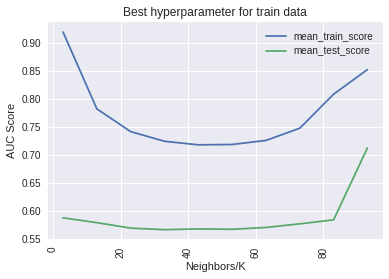

In [0]:
# Please write all the code with proper documentation

#Parameters
params = {"n_neighbors":[3,13,23,33,43,53,63,73,83,93]
         }
knn_bow = KNeighborsClassifier(algorithm = "brute")

gridcv = GridSearchCV(knn_bow, params, scoring = 'roc_auc', cv = 5)
gridcv.fit(final_tf_idf, y_train)
print(gridcv.best_params_)

bst_paramtr = gridcv.best_params_["n_neighbors"] #The best hyperparameter

#Plots the graph for all  parameters to find best hyperparameter.
plot_best_hyperparameter(gridcv)

AUC for KNN with TFIDF for brute force method:  0.5777730333765929


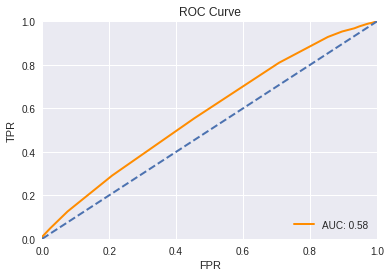

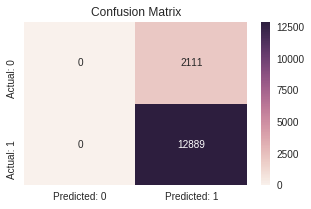

In [0]:
knn_bow_1 = KNeighborsClassifier(n_neighbors = bst_paramtr ,algorithm = "brute")
knn_bow_1.fit(final_tf_idf, y_train)

y_predict_proba_tfidf = knn_bow_1.predict_proba(final_tf_idf_test)[:,1]
y_predict_tfidf = knn_bow_1.predict(final_tf_idf_test)

roc_auc = roc_auc_score(y_test, y_predict_proba_tfidf)

print("AUC for KNN with TFIDF for brute force method: ", roc_auc)

#Plots ROC curve
plot_roc_curve(y_test, y_predict_proba_tfidf)

#Plots Confusion matrix
plot_confusion_mat(y_test, y_predict_tfidf)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

{'n_neighbors': 83}


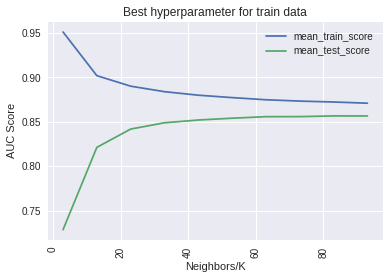

In [0]:
# Please write all the code with proper documentation

#Parameters
params = {"n_neighbors":[3,13,23,33,43,53,63,73,83,93]
         }

knn_bow = KNeighborsClassifier(algorithm = "brute")

gridcv = GridSearchCV(knn_bow, params, scoring = 'roc_auc', cv = 5)
gridcv.fit(X_tr_w2v, y_train)
print(gridcv.best_params_)

bst_paramtr = gridcv.best_params_["n_neighbors"]

#Plots the graph for all  parameters to find best hyperparameter.
plot_best_hyperparameter(gridcv)

AUC for KNN with AVG W2V for KD Tree method:  0.8482575357664369


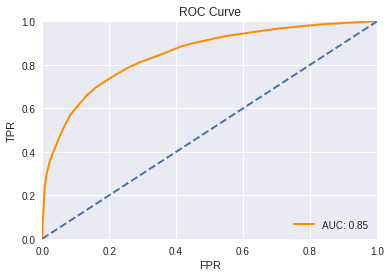

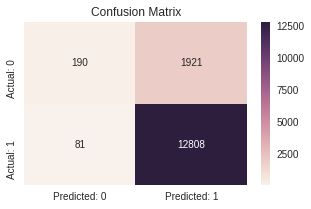

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

knn_bow_1 = KNeighborsClassifier(n_neighbors = bst_paramtr , algorithm = "brute")
knn_bow_1.fit(X_tr_w2v, y_train)

y_predict_proba_w2v_kd = knn_bow_1.predict_proba(X_ts_w2v)[:,1]
y_predict_w2v_kd = knn_bow_1.predict(X_ts_w2v)

roc_auc = roc_auc_score(y_test, y_predict_proba_w2v_kd)

print("AUC for KNN with AVG W2V for KD Tree method: ", roc_auc)

#Plots ROC curve 
plot_roc_curve(y_test, y_predict_proba_w2v_kd)

#Plots Confusion matrix
plot_confusion_mat(y_test, y_predict_w2v_kd)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

{'n_neighbors': 83}


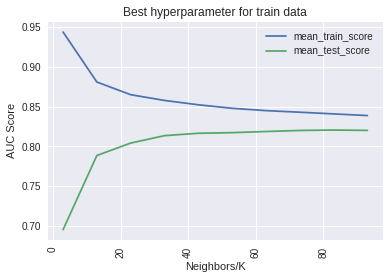

In [0]:
# Please write all the code with proper documentation

#Parameters
params = {"n_neighbors":[3,13,23,33,43,53,63,73,83,93]
         }

knn_bow = KNeighborsClassifier(algorithm = "brute")

gridcv = GridSearchCV(knn_bow, params, scoring = 'roc_auc', cv = 5)
gridcv.fit(X_tr_tf, y_train)
print(gridcv.best_params_)

bst_paramtr = gridcv.best_params_["n_neighbors"]

#Plots the graph for all  parameters to find best hyperparameter.
plot_best_hyperparameter(gridcv)

AUC for KNN with TFIDF W2V for KD Tree method:  0.815509768041293


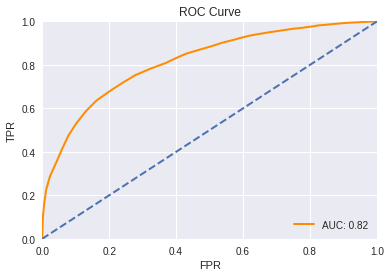

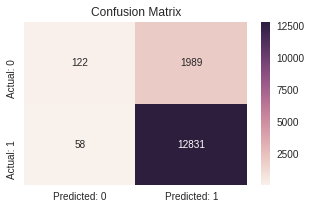

In [0]:
knn_bow_1 = KNeighborsClassifier(n_neighbors = bst_paramtr , algorithm = "brute")
knn_bow_1.fit(X_tr_tf, y_train)

y_predict_proba_tfidf_w2v_kd = knn_bow_1.predict_proba(X_ts_tf)[:,1]
y_predict_tfidf_w2v_kd = knn_bow_1.predict(X_ts_tf)

roc_auc = roc_auc_score(y_test, y_predict_proba_tfidf_w2v_kd)

print("AUC for KNN with TFIDF W2V for KD Tree method: ", roc_auc)

#Plots ROC curve
plot_roc_curve(y_test, y_predict_proba_tfidf_w2v_kd)

#Plots Confusion matrix
plot_confusion_mat(y_test, y_predict_tfidf_w2v_kd)

# Note: I ran the above models with KD Tree algorithm in next ipython notebook. Conclusions are also mentioned in that notebook.